In [2]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [10]:


# ==========================================
# 1. Configuración inicial
# ==========================================
# Fijar semilla para que los resultados sean reproducibles
np.random.seed(42)

# Parámetros del diseño muestral
n_total = 200
sectores = ['A', 'B', 'C']
# Probabilidades para muestreo estratificado (aprox. balanceado)
prob_sector = [0.34, 0.33, 0.33] 

# ==========================================
# 2. Generación de variables independientes
# ==========================================
# Crear DataFrame vacío
df = pd.DataFrame()

# ID de turno
df['id_turno'] = range(1, n_total + 1)

# Variable cualitativa: Sector (A, B, C)
df['sector'] = np.random.choice(sectores, n_total, p=prob_sector)

# Variable cualitativa: Turno (Día, Noche)
df['shift'] = np.random.choice(['Día', 'Noche'], n_total)

# Variable cuantitativa: Profundidad (m)
# Simulamos profundidad entre 500m y 1200m
df['depth_m'] = np.random.uniform(500, 1200, n_total)

# Variable cuantitativa: Calidad de roca (GSI)
# Valor entero entre 35 (mala) y 85 (muy buena)
df['gsi'] = np.random.randint(35, 85, n_total)

# ==========================================
# 3. Modelado de variables dependientes
# ==========================================

# A) Stress (MPa): 
# Modelo físico simple: aumenta con profundidad (0.04 MPa/m) + ruido aleatorio
# Ruido normal con media 0 y desviación 8 para dar variabilidad
df['stress_mpa'] = 0.04 * df['depth_m'] + np.random.normal(0, 8, n_total)
# Asegurar que no haya valores negativos o irreales (mínimo 10 MPa)
df['stress_mpa'] = df['stress_mpa'].clip(lower=10)

# B) Sismicidad (Conteo de eventos):
# Modelado como distribución Poisson donde lambda depende del stress
# A mayor stress, mayor tasa media de eventos
lambda_seismic = df['stress_mpa'] / 10  # Factor de escala arbitrario
df['seismic_events_count'] = np.random.poisson(lambda_seismic)

# ==========================================
# 4. Generación de Variable Objetivo (Rockburst)
# ==========================================
# Usamos un modelo logístico para determinar la PROBABILIDAD de rockburst
# Logit = b0 + b1*stress + b2*eventos
# Ajustamos coeficientes para que los eventos sean "raros" pero correlacionados
logit = -9.5 + 0.15 * df['stress_mpa'] + 0.1 * df['seismic_events_count']

# Función sigmoide para convertir logit a probabilidad (0 a 1)
prob_rockburst = 1 / (1 + np.exp(-logit))

# Generar 0 o 1 usando distribución binomial (Bernoulli) con esa probabilidad
df['rockburst'] = np.random.binomial(1, prob_rockburst)

# ==========================================
# 5. Variables consecuencia (Post-evento)
# ==========================================
# PPV (Peak Particle Velocity): 
# Si hubo rockburst, PPV es alto (Gamma dist); si no, es ruido de fondo bajo
df['ppv_mm_s'] = np.where(df['rockburst'] == 1, 
                          np.random.gamma(shape=10, scale=10, size=n_total), # Eventos fuertes
                          np.random.gamma(shape=2, scale=2, size=n_total))   # Ruido fondo

# ==========================================
# 6. Limpieza y guardado
# ==========================================
# Redondear decimales
df['stress_mpa'] = df['stress_mpa'].round(2)
df['ppv_mm_s'] = df['ppv_mm_s'].round(2)
df['depth_m'] = df['depth_m'].astype(int)

# Mostrar resumen
print("Dataset generado con éxito!")
print(f"Dimensiones: {df.shape}")
print("\nConteo de casos Rockburst:")
print(df['rockburst'].value_counts())
print("\nEstadísticas descriptivas (Stress):")
print(df.groupby('rockburst')['stress_mpa'].describe())
print(df.head(5))

# Guardar a CSV (opcional)
df.to_csv('dataset_geotecnia_rockburst.csv', index=False)


Dataset generado con éxito!
Dimensiones: (200, 9)

Conteo de casos Rockburst:
rockburst
0    188
1     12
Name: count, dtype: int64

Estadísticas descriptivas (Stress):
           count       mean        std    min      25%     50%      75%    max
rockburst                                                                     
0          188.0  32.830426  11.477189  10.00  22.9025  32.945  41.3075  67.17
1           12.0  49.349167  10.894793  30.14  44.8550  49.475  56.6700  68.63
   id_turno sector  shift  depth_m  gsi  stress_mpa  seismic_events_count  \
0         1      B  Noche      536   51       21.68                     2   
1         2      C  Noche      871   43       42.63                     1   
2         3      C    Día      878   67       27.36                     2   
3         4      B    Día      946   54       38.48                     3   
4         5      A  Noche     1008   47       52.52                     4   

   rockburst  ppv_mm_s  
0          0      1.66  
1 

In [4]:
# ==========================================
# CÁLCULO DE PROBABILIDADES (Lección 2)
# ==========================================

# 1. Definir umbrales para los eventos
# Umbral para "Stress Alto" (Evento B): Usamos el percentil 75
umbral_stress = df['stress_mpa'].quantile(0.75)

# Umbral para "Alta Sismicidad" (Evento C): Ejemplo, >= 4 eventos
umbral_sismicidad = 4

print(f"--- Umbrales definidos ---")
print(f"Umbral Stress Alto (B): >= {umbral_stress:.2f} MPa")
print(f"Umbral Alta Sismicidad (C): >= {umbral_sismicidad} eventos\n")

# 2. Crear columnas booleanas para facilitar cálculos
# Evento A: Rockburst
df['evento_A'] = df['rockburst'] == 1
# Evento B: Stress Alto
df['evento_B'] = df['stress_mpa'] >= umbral_stress
# Evento C: Alta Sismicidad
df['evento_C'] = df['seismic_events_count'] >= umbral_sismicidad

n = len(df)

# 3. Probabilidades Marginales y Complementos
prob_A = df['evento_A'].mean()
prob_A_complemento = 1 - prob_A

print(f"--- Probabilidades Marginales ---")
print(f"P(A) [Rockburst]: {prob_A:.4f} ({df['evento_A'].sum()}/{n})")
print(f"P(A') [No Rockburst]: {prob_A_complemento:.4f}\n")

# 4. Intersección: P(A ∩ B) -> Rockburst Y Stress Alto
interseccion_AB = (df['evento_A'] & df['evento_B']).mean()
print(f"--- Intersección P(A ∩ B) ---")
print(f"Probabilidad de Rockburst Y Stress Alto: {interseccion_AB:.4f}")

# 5. Unión: P(A U C) -> Rockburst O Alta Sismicidad
# Fórmula teórica: P(A) + P(C) - P(A ∩ C)
prob_C = df['evento_C'].mean()
interseccion_AC = (df['evento_A'] & df['evento_C']).mean()
union_AC = prob_A + prob_C - interseccion_AC

# Verificación empírica (contando filas que cumplen A o C)
union_AC_empirica = (df['evento_A'] | df['evento_C']).mean()

print(f"--- Unión P(A U C) ---")
print(f"Probabilidad de Rockburst O Alta Sismicidad: {union_AC:.4f}")
print(f"(Verificación empírica: {union_AC_empirica:.4f})\n")

# 6. Probabilidades Condicionales (Para el Árbol)
# P(A | B) = P(A ∩ B) / P(B)
prob_B = df['evento_B'].mean()
prob_A_dado_B = interseccion_AB / prob_B if prob_B > 0 else 0

# P(A | no B)
prob_no_B = 1 - prob_B
interseccion_A_noB = (df['evento_A'] & (~df['evento_B'])).mean()
prob_A_dado_no_B = interseccion_A_noB / prob_no_B if prob_no_B > 0 else 0

print(f"--- Probabilidades Condicionales (Para el Árbol) ---")
print(f"P(B) [Stress Alto]: {prob_B:.4f}")
print(f"P(A | B) [Rockburst dado Stress Alto]: {prob_A_dado_B:.4f}")
print(f"P(A | no B) [Rockburst dado Stress Normal]: {prob_A_dado_no_B:.4f}")


--- Umbrales definidos ---
Umbral Stress Alto (B): >= 43.28 MPa
Umbral Alta Sismicidad (C): >= 4 eventos

--- Probabilidades Marginales ---
P(A) [Rockburst]: 0.0600 (12/200)
P(A') [No Rockburst]: 0.9400

--- Intersección P(A ∩ B) ---
Probabilidad de Rockburst Y Stress Alto: 0.0500
--- Unión P(A U C) ---
Probabilidad de Rockburst O Alta Sismicidad: 0.4450
(Verificación empírica: 0.4450)

--- Probabilidades Condicionales (Para el Árbol) ---
P(B) [Stress Alto]: 0.2500
P(A | B) [Rockburst dado Stress Alto]: 0.2000
P(A | no B) [Rockburst dado Stress Normal]: 0.0133


<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:52: SyntaxWarning: invalid escape sequence '\l'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:52: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_2121/1955348799.py:26: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_axis, stats.norm.pdf(x_axis, mu_stress, sigma_stress), 'r-', label=f'Normal($\mu$={mu_stress:.1f}, $\sigma$={sigma_stress:.1f})')
/tmp/ipykernel_2121/1955348799.py:26: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_axis, stats.norm.pdf(x_axis, mu_stress, sigma_stress), 'r-', label=f'Normal($\mu$={mu_stress:.1f}, $\sigma$={sigma_stress:.1f})')
/tmp/ipykernel_2121/1955348799.py:52: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(x_pois, y_pois, 'ro--', label=f'Poisson($\lambda$={lambda_sismicidad:.1f})')


--- Distribución Normal (Stress) ---
Media estimada (mu): 33.82 MPa
Desviación estándar (sigma): 12.08 MPa
Probabilidad teórica P(Stress > 45): 0.1773


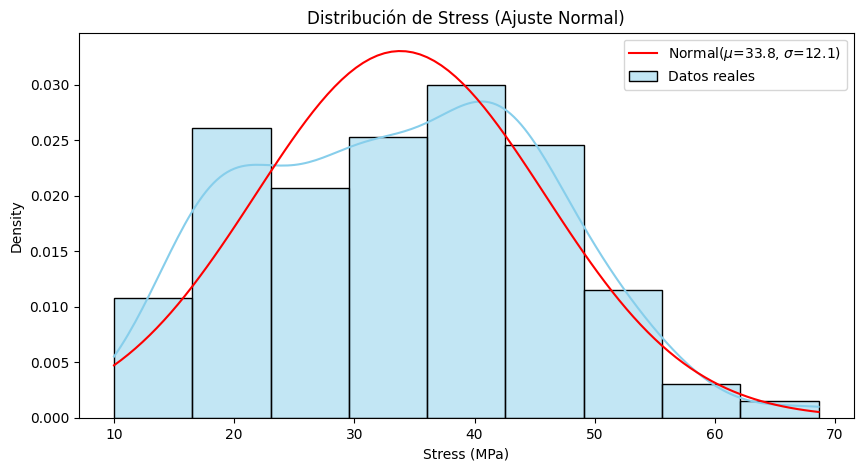


--- Distribución Poisson (Sismicidad) ---
Tasa promedio (lambda): 3.42 eventos/turno
Probabilidad teórica P(Eventos >= 5): 0.2586


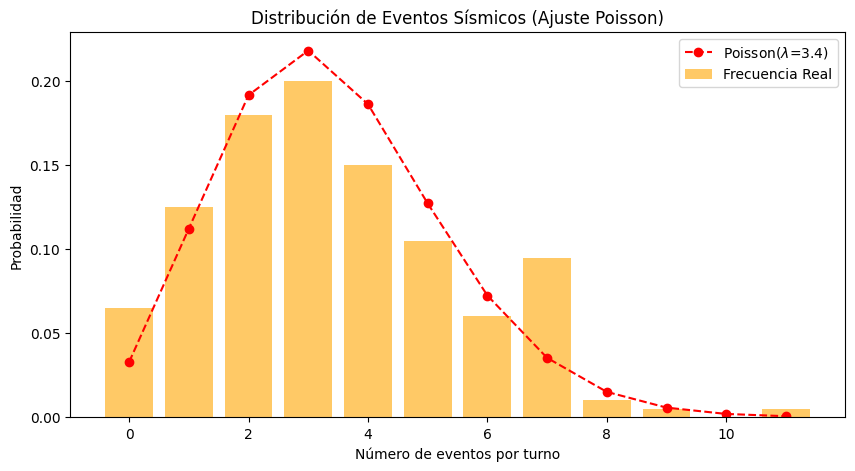

In [5]:
import scipy.stats as stats
import seaborn as sns

# ==========================================
# LECCIÓN 3: DISTRIBUCIONES DE PROBABILIDAD
# ==========================================

# A) Distribución Normal (Stress)
# ------------------------------------------
mu_stress = df['stress_mpa'].mean()
sigma_stress = df['stress_mpa'].std()

print(f"--- Distribución Normal (Stress) ---")
print(f"Media estimada (mu): {mu_stress:.2f} MPa")
print(f"Desviación estándar (sigma): {sigma_stress:.2f} MPa")

# Cálculo de probabilidad teórica: P(Stress > 45 MPa)
prob_teorica_stress_45 = 1 - stats.norm.cdf(45, loc=mu_stress, scale=sigma_stress)
print(f"Probabilidad teórica P(Stress > 45): {prob_teorica_stress_45:.4f}")

# Gráfico
plt.figure(figsize=(10, 5))
sns.histplot(df['stress_mpa'], kde=True, stat="density", label="Datos reales", color="skyblue")
# Curva teórica
x_axis = np.linspace(df['stress_mpa'].min(), df['stress_mpa'].max(), 100)
plt.plot(x_axis, stats.norm.pdf(x_axis, mu_stress, sigma_stress), 'r-', label=f'Normal($\mu$={mu_stress:.1f}, $\sigma$={sigma_stress:.1f})')
plt.title("Distribución de Stress (Ajuste Normal)")
plt.xlabel("Stress (MPa)")
plt.legend()
plt.show()

# B) Distribución Poisson (Sismicidad)
# ------------------------------------------
lambda_sismicidad = df['seismic_events_count'].mean()

print(f"\n--- Distribución Poisson (Sismicidad) ---")
print(f"Tasa promedio (lambda): {lambda_sismicidad:.2f} eventos/turno")

# Cálculo probabilidad teórica: P(X >= 5 eventos)
# 1 - P(X <= 4) = 1 - cdf(4)
prob_teorica_5_eventos = 1 - stats.poisson.cdf(4, mu=lambda_sismicidad)
print(f"Probabilidad teórica P(Eventos >= 5): {prob_teorica_5_eventos:.4f}")

# Gráfico
plt.figure(figsize=(10, 5))
conteo_real = df['seismic_events_count'].value_counts(normalize=True).sort_index()
plt.bar(conteo_real.index, conteo_real.values, alpha=0.6, label="Frecuencia Real", color="orange")

# Probabilidades teóricas Poisson
x_pois = np.arange(0, df['seismic_events_count'].max() + 1)
y_pois = stats.poisson.pmf(x_pois, lambda_sismicidad)
plt.plot(x_pois, y_pois, 'ro--', label=f'Poisson($\lambda$={lambda_sismicidad:.1f})')

plt.title("Distribución de Eventos Sísmicos (Ajuste Poisson)")
plt.xlabel("Número de eventos por turno")
plt.ylabel("Probabilidad")
plt.legend()
plt.show()


--- Distribución Binomial (Rockburst) ---
Parámetros estimados: n=20, p=0.0600


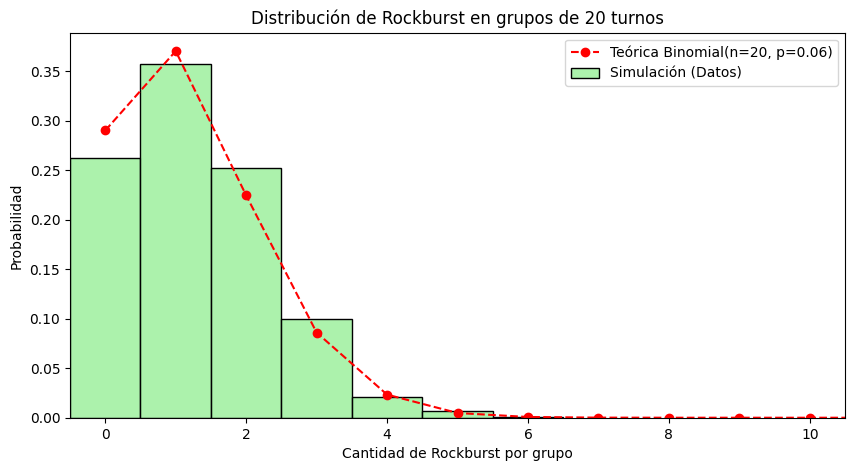

In [6]:
# ==========================================
# C) Distribución Binomial (Rockburst)
# ==========================================
# Para validar la Binomial, simulamos "experimentos" de agrupar turnos.
# Ejemplo: Tomamos 1000 muestras de tamaño n=20 turnos cada una.
# Contamos cuántos rockburst ocurren en cada muestra.

n_experimentos = 1000
tamano_muestra = 20  # n para la Binomial
prob_rockburst = df['rockburst'].mean() # p estimado

# Simulación de conteos (Bootstrapping simple)
conteos_rockburst = [np.random.choice(df['rockburst'], tamano_muestra).sum() for _ in range(n_experimentos)]

print(f"--- Distribución Binomial (Rockburst) ---")
print(f"Parámetros estimados: n={tamano_muestra}, p={prob_rockburst:.4f}")

# Gráfico
plt.figure(figsize=(10, 5))
# Histograma de los conteos simulados
sns.histplot(conteos_rockburst, discrete=True, stat="probability", label="Simulación (Datos)", color="lightgreen")

# Probabilidad Teórica Binomial
x_binom = np.arange(0, tamano_muestra + 1)
y_binom = stats.binom.pmf(x_binom, n=tamano_muestra, p=prob_rockburst)
plt.plot(x_binom, y_binom, 'ro--', label=f'Teórica Binomial(n={tamano_muestra}, p={prob_rockburst:.2f})')

plt.title(f"Distribución de Rockburst en grupos de {tamano_muestra} turnos")
plt.xlabel("Cantidad de Rockburst por grupo")
plt.ylabel("Probabilidad")
plt.xlim(-0.5, 10.5) # Ajustar zoom porque p es bajo
plt.legend()
plt.show()


--- Parámetros Poblacionales (stress_mpa) ---
Media (mu): 33.82
Desviación Estándar (sigma): 12.08

--- Verificación Empírica del TLC ---
Para n=30:
  Media de medias: 33.92 (Esperado: 33.82)
  Error Estándar simulado: 2.18
  Error Estándar teórico (sigma/sqrt(n)): 2.20

Para n=100:
  Media de medias: 33.88 (Esperado: 33.82)
  Error Estándar simulado: 1.18
  Error Estándar teórico (sigma/sqrt(n)): 1.21


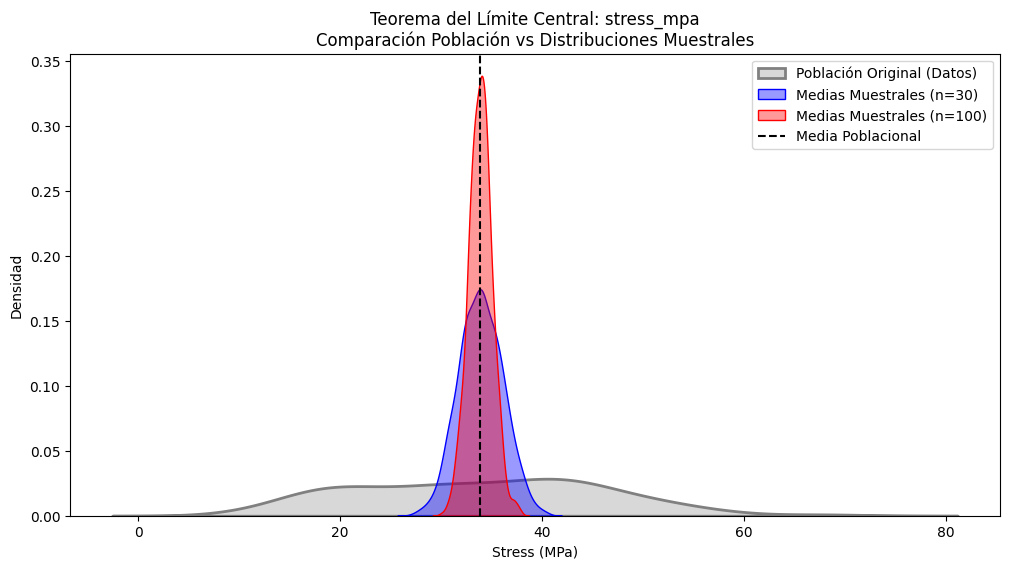

In [7]:
# ==========================================
# LECCIÓN 4: TEOREMA DEL LÍMITE CENTRAL (TLC)
# ==========================================

variable = 'stress_mpa'
poblacion = df[variable]
mu_poblacional = poblacion.mean()
sigma_poblacional = poblacion.std()

print(f"--- Parámetros Poblacionales ({variable}) ---")
print(f"Media (mu): {mu_poblacional:.2f}")
print(f"Desviación Estándar (sigma): {sigma_poblacional:.2f}\n")

# Función para generar medias muestrales
def generar_medias_muestrales(datos, n_muestra, n_repeticiones=1000):
    medias = []
    for _ in range(n_repeticiones):
        muestra = np.random.choice(datos, size=n_muestra, replace=True)
        medias.append(muestra.mean())
    return np.array(medias)

# Simulación: Generar distribuciones muestrales con distintos tamaños n
n_small = 30
n_large = 100

medias_n30 = generar_medias_muestrales(poblacion, n_small)
medias_n100 = generar_medias_muestrales(poblacion, n_large)

# Análisis de Dispersión (Error Estándar)
print(f"--- Verificación Empírica del TLC ---")
print(f"Para n={n_small}:")
print(f"  Media de medias: {medias_n30.mean():.2f} (Esperado: {mu_poblacional:.2f})")
print(f"  Error Estándar simulado: {medias_n30.std():.2f}")
print(f"  Error Estándar teórico (sigma/sqrt(n)): {sigma_poblacional/np.sqrt(n_small):.2f}")

print(f"\nPara n={n_large}:")
print(f"  Media de medias: {medias_n100.mean():.2f} (Esperado: {mu_poblacional:.2f})")
print(f"  Error Estándar simulado: {medias_n100.std():.2f}")
print(f"  Error Estándar teórico (sigma/sqrt(n)): {sigma_poblacional/np.sqrt(n_large):.2f}")

# Gráfico Comparativo
plt.figure(figsize=(12, 6))

# 1. Población original (histograma de fondo)
sns.kdeplot(poblacion, fill=True, color='grey', alpha=0.3, label='Población Original (Datos)', linewidth=2)

# 2. Distribución muestral n=30
sns.kdeplot(medias_n30, fill=True, color='blue', alpha=0.4, label=f'Medias Muestrales (n={n_small})')

# 3. Distribución muestral n=100
sns.kdeplot(medias_n100, fill=True, color='red', alpha=0.4, label=f'Medias Muestrales (n={n_large})')

plt.axvline(mu_poblacional, color='k', linestyle='--', label='Media Poblacional')
plt.title(f"Teorema del Límite Central: {variable}\nComparación Población vs Distribuciones Muestrales")
plt.xlabel("Stress (MPa)")
plt.ylabel("Densidad")
plt.legend()
plt.show()


--- Resultados de Intervalos de Confianza ---

Variable: stress_mpa (Media Muestral: 33.82)
  IC 90%: [32.41, 35.23] (Ancho: 2.82)
  IC 95%: [32.14, 35.51] (Ancho: 3.37)
  IC 99%: [31.60, 36.04] (Ancho: 4.44)

Variable: ppv_mm_s (Media Muestral: 9.95)
  IC 90%: [7.04, 12.87] (Ancho: 5.83)
  IC 95%: [6.48, 13.43] (Ancho: 6.95)
  IC 99%: [5.37, 14.54] (Ancho: 9.17)

--- Impacto del Tamaño Muestral (Variable: stress_mpa, Confianza: 95%) ---
  n=10: Ancho del intervalo = 21.63
  n=30: Ancho del intervalo = 8.29
  n=50: Ancho del intervalo = 6.34
  n=100: Ancho del intervalo = 4.59
  n=200: Ancho del intervalo = 3.37


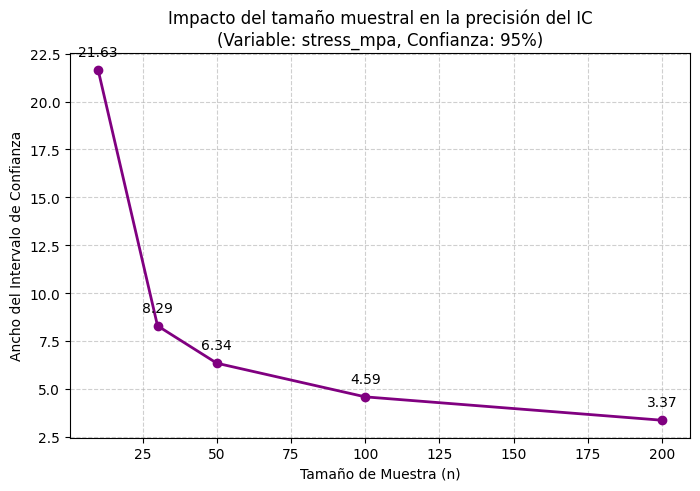

In [8]:
# ==========================================
# LECCIÓN 5: INTERVALOS DE CONFIANZA
# ==========================================

# 1. Definir función para calcular IC de la media (usando distribución t-Student)
# Se usa t-Student porque no conocemos la sigma real poblacional, solo la muestral (s)
def calcular_intervalo_confianza(datos, confianza=0.95):
    n = len(datos)
    media = np.mean(datos)
    error_estandar = stats.sem(datos) # s / sqrt(n)
    # Intervalo usando t-student con n-1 grados de libertad
    intervalo = stats.t.interval(confianza, df=n-1, loc=media, scale=error_estandar)
    ancho = intervalo[1] - intervalo[0]
    return media, intervalo, ancho

# 2. Calcular IC para dos variables con distintos niveles (90, 95, 99)
variables_analisis = ['stress_mpa', 'ppv_mm_s']
niveles_confianza = [0.90, 0.95, 0.99]

resultados_ic = []

print("--- Resultados de Intervalos de Confianza ---")

for var in variables_analisis:
    datos_var = df[var]
    print(f"\nVariable: {var} (Media Muestral: {datos_var.mean():.2f})")
    
    for conf in niveles_confianza:
        media, (lim_inf, lim_sup), ancho = calcular_intervalo_confianza(datos_var, conf)
        resultados_ic.append({
            'Variable': var,
            'Nivel Confianza': f"{int(conf*100)}%",
            'Límite Inferior': lim_inf,
            'Límite Superior': lim_sup,
            'Ancho': ancho
        })
        print(f"  IC {int(conf*100)}%: [{lim_inf:.2f}, {lim_sup:.2f}] (Ancho: {ancho:.2f})")

# 3. Análisis de impacto del tamaño muestral (n) en el ancho del IC
# Simulamos tomar sub-muestras de tamaño creciente (10, 50, 100, 200)
tamanos_n = [10, 30, 50, 100, 200]
anchos_por_n = []
variable_n = 'stress_mpa'

print(f"\n--- Impacto del Tamaño Muestral (Variable: {variable_n}, Confianza: 95%) ---")
for n_sim in tamanos_n:
    # Tomamos una sub-muestra aleatoria de tamaño n_sim
    sub_muestra = np.random.choice(df[variable_n], size=n_sim, replace=False) # Sin reemplazo porque es "recortar" el dataset
    _, _, ancho_sim = calcular_intervalo_confianza(sub_muestra, 0.95)
    anchos_por_n.append(ancho_sim)
    print(f"  n={n_sim}: Ancho del intervalo = {ancho_sim:.2f}")

# 4. Gráfico de Anchos de Intervalo vs Tamaño Muestral
plt.figure(figsize=(8, 5))
plt.plot(tamanos_n, anchos_por_n, 'o-', color='purple', linewidth=2)
plt.title(f"Impacto del tamaño muestral en la precisión del IC\n(Variable: {variable_n}, Confianza: 95%)")
plt.xlabel("Tamaño de Muestra (n)")
plt.ylabel("Ancho del Intervalo de Confianza")
plt.grid(True, linestyle='--', alpha=0.6)
for i, txt in enumerate(anchos_por_n):
    plt.annotate(f"{txt:.2f}", (tamanos_n[i], anchos_por_n[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()


--- Prueba de Hipótesis para Diferencia de Medias ---
H0: Media Stress (Rockburst) <= Media Stress (No Rockburst)
H1: Media Stress (Rockburst) > Media Stress (No Rockburst)
Nivel de significancia (alpha): 0.05

Grupo CON Rockburst: n=12, Media=49.35, Desv=10.89
Grupo SIN Rockburst: n=188, Media=32.83, Desv=11.48

--- Resultados del Test ---
Estadístico t: 5.0756
Valor-p (p-value): 0.0001168647

Decisión: RECHAZAR H0
Conclusión: Existe evidencia estadística suficiente para afirmar que el stress promedio es significativamente mayor en los turnos con rockburst.


/tmp/ipykernel_2121/4155183109.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rockburst', y='stress_mpa', data=df, palette=['lightblue', 'salmon'])


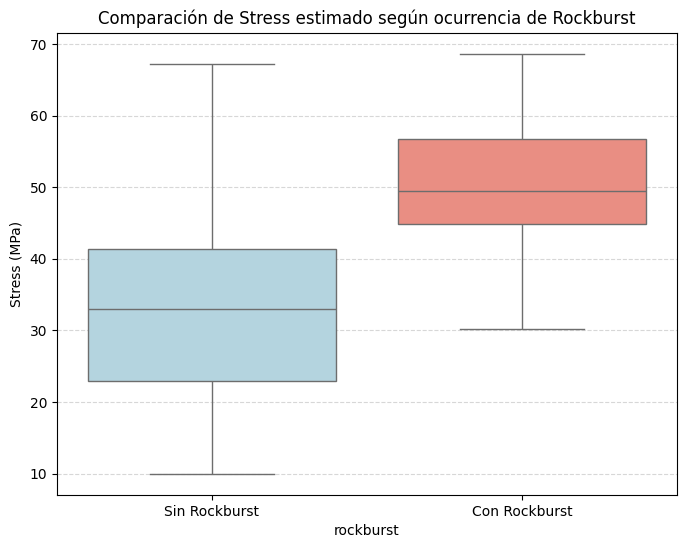

In [9]:
# ==========================================
# LECCIÓN 6: TEST DE SIGNIFICANCIA (PRUEBA DE HIPÓTESIS)
# ==========================================
from scipy.stats import ttest_ind

# 1. Definir Hipótesis y Nivel de Significancia
alpha = 0.05
print(f"--- Prueba de Hipótesis para Diferencia de Medias ---")
print(f"H0: Media Stress (Rockburst) <= Media Stress (No Rockburst)")
print(f"H1: Media Stress (Rockburst) > Media Stress (No Rockburst)")
print(f"Nivel de significancia (alpha): {alpha}\n")

# 2. Separar los grupos
grupo_con_rockburst = df[df['rockburst'] == 1]['stress_mpa']
grupo_sin_rockburst = df[df['rockburst'] == 0]['stress_mpa']

# Calcular estadísticos descriptivos básicos
n1, n2 = len(grupo_con_rockburst), len(grupo_sin_rockburst)
media1, media2 = grupo_con_rockburst.mean(), grupo_sin_rockburst.mean()
std1, std2 = grupo_con_rockburst.std(), grupo_sin_rockburst.std()

print(f"Grupo CON Rockburst: n={n1}, Media={media1:.2f}, Desv={std1:.2f}")
print(f"Grupo SIN Rockburst: n={n2}, Media={media2:.2f}, Desv={std2:.2f}\n")

# 3. Ejecutar Test t-Student (Welch's t-test, asume varianzas desiguales)
# alternative='greater' porque H1 dice que el grupo Rockburst es MAYOR
t_stat, p_value = ttest_ind(grupo_con_rockburst, grupo_sin_rockburst, equal_var=False, alternative='greater')

print(f"--- Resultados del Test ---")
print(f"Estadístico t: {t_stat:.4f}")
print(f"Valor-p (p-value): {p_value:.10f}") # Formato decimal largo por si es muy pequeño

# 4. Toma de Decisión
if p_value < alpha:
    decision = "RECHAZAR H0"
    conclusion = "Existe evidencia estadística suficiente para afirmar que el stress promedio es significativamente mayor en los turnos con rockburst."
else:
    decision = "NO RECHAZAR H0"
    conclusion = "No existe evidencia suficiente para afirmar que el stress promedio sea mayor en turnos con rockburst."

print(f"\nDecisión: {decision}")
print(f"Conclusión: {conclusion}")

# Gráfico de cajas para visualizar la diferencia
plt.figure(figsize=(8, 6))
sns.boxplot(x='rockburst', y='stress_mpa', data=df, palette=['lightblue', 'salmon'])
plt.xticks([0, 1], ['Sin Rockburst', 'Con Rockburst'])
plt.title("Comparación de Stress estimado según ocurrencia de Rockburst")
plt.ylabel("Stress (MPa)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
